In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.0 MB/s eta 0:00:00


In [ ]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=f01b22048f046a421ff0c25771a1443c5fe65139f5f8a1b94f134deda69e6a3a
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [ ]:
import cv2
from mtcnn import MTCNN
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras_facenet import FaceNet
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models

# Function to get face embeddings using FaceNet
def get_embedding(face):
    return embedder.embeddings([face])[0]

# Load the dataset from Google Drive
dataset_folder = '/content/gdrive/MyDrive/images'
csv_file_path = '/content/gdrive/MyDrive/img/images.csv'  # Change this to your CSV file path
mtcnn = MTCNN()
embedder = FaceNet()

# Create a list to store cropped faces, labels, and embeddings
cropped_faces = []
labels = []
face_embeddings = []

# Read labels from CSV file
df_labels = pd.read_csv(csv_file_path)

# Process all images in the dataset
for index, row in df_labels.iterrows():
    filename = row['id']  # Change 'Image' to the actual column name in your CSV file
    image_path = os.path.join(dataset_folder, filename)

    # Check if the file is an image based on its extension
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']  # Add more if needed
    if any(image_path.lower().endswith(ext) for ext in valid_extensions):
        img = cv2.imread(image_path)

        label = row['label']  # Change 'Label' to the actual column name in your CSV file

        # Detect faces using MTCNN
        faces = mtcnn.detect_faces(img)

        if faces:
            # Assuming there is only one face per image
            x, y, w, h = faces[0]['box']
            cropped_face = img[y:y+h, x:x+w]

            # Augment the cropped face using ImageDataGenerator
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

            # Reshape the image to (1, height, width, channels) for the generator
            face_img = np.expand_dims(cropped_face, axis=0)

            # Generate augmented images
            augmented_faces = datagen.flow(face_img, batch_size=1)

            # Get embeddings for augmented faces
            for _ in range(5):  # Adjust the number of augmented images as needed
                augmented_face = augmented_faces.next()[0]
                augmented_embedding = get_embedding(augmented_face)
                cropped_faces.append(augmented_face)
                labels.append(label)
                face_embeddings.append(augmented_embedding)



# Convert the list of embeddings to a numpy array
face_embeddings = np.array(face_embeddings)

# Encode labels using LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

# Split the data into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(face_embeddings, labels, shuffle=True, random_state=17)


1/1 [==============================] - 0s 27ms/step


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Normalize each column separately in face_embeddings
# normalized_embeddings = scaler.fit_transform(face_embeddings)

# Now, normalized_embeddings contains the normalized values for each column separately

# Example usage:
# print("Original Embeddings:")
# print(face_embeddings)
# print("\nNormalized Embeddings:")
# print(normalized_embeddings)
X_train, X_test, Y_train, Y_test = train_test_split(face_embeddings, labels, shuffle=True, random_state=17)


In [ ]:
# from tqdm import tqdm

# plt.figure(figsize=(20, 15))
# num_to_display = min(3, len(cropped_faces))

# for num in tqdm(range(num_to_display)):
#     ncols = 3
#     nrows = num_to_display // ncols + 1
#     plt.subplot(nrows, ncols, num + 1)
#     plt.imshow(cv2.cvtColor(cropped_faces[num], cv2.COLOR_BGR2RGB))
#     # plt.title(f"Label: {labels[num]}")
#     plt.axis('off')

# plt.show()



In [ ]:
len(face_embeddings)

525

In [ ]:
len(face_embeddings)

525

In [ ]:
X_train.shape

(393, 512)

In [ ]:
X_test.shape

(132, 512)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Build and compile the model
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(512,)))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))  # Use the number of unique labels

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))




Epoch 1/100
7/7 [==============================] - 3s 56ms/step - loss: 4.6507 - accuracy: 0.0153 - val_loss: 4.6428 - val_accuracy: 0.0227
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 4.6195 - accuracy: 0.0382 - val_loss: 4.6329 - val_accuracy: 0.0152
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 4.5832 - accuracy: 0.0865 - val_loss: 4.6180 - val_accuracy: 0.0303
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 4.5394 - accuracy: 0.0916 - val_loss: 4.5990 - val_accuracy: 0.0455
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 4.4810 - accuracy: 0.1196 - val_loss: 4.5697 - val_accuracy: 0.0455
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 4.4074 - accuracy: 0.1425 - val_loss: 4.5305 - val_accuracy: 0.0455
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 4.3049 - accuracy: 0.1603 - val_loss: 4.4910 - val_accuracy: 0.0303
Epoch 8/100
7/7 [======

In [ ]:
# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test, Y_test)

# Print the accuracy
print("Test Accuracy: {:.2%}".format(accuracy))


5/5 [==============================] - 0s 4ms/step - loss: 1.9790 - accuracy: 0.6742
Test Accuracy: 67.42%


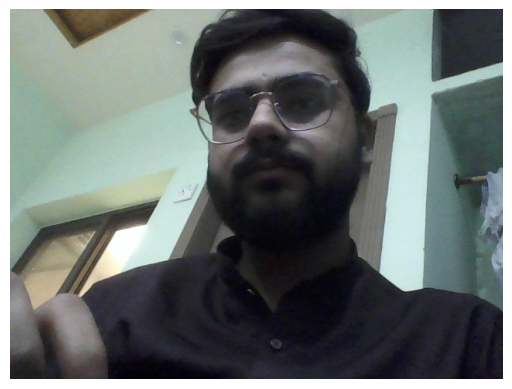

<IPython.core.display.Javascript object>

Image saved as captured_image.jpg


In [ ]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
import base64  # Add this import statement for base64 encoding

# Use the 'cv2_imshow' function for displaying images in Colab
def cv2_imshow(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# JavaScript code to simulate key events in Colab
def simulate_keypress():
    display(Javascript('''
        document.dispatchEvent(new KeyboardEvent('keydown', {key: ' ', code: 'Space'}));
    '''))

# Open the webcam, capture an image, and turn off the camera
def capture_image():
    js_code = '''
        async function captureImage() {
            const video = document.createElement('video');
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });

            video.srcObject = stream;
            await video.play();

            // Wait for a moment to allow the video stream to initialize
            await new Promise(resolve => setTimeout(resolve, 5000));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;

            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0, canvas.width, canvas.height);

            // Stop the video stream
            const tracks = stream.getTracks();
            tracks.forEach(track => track.stop());

            // Remove the video element
            document.body.removeChild(video);

            // Convert canvas to base64-encoded image
            const imageData = canvas.toDataURL('image/jpeg');
            return imageData;
        }

        captureImage();
    '''

    # Capture image using JavaScript
    image_data = eval_js(js_code)

    # Convert base64-encoded image to NumPy array
    image_np = np.frombuffer(base64.b64decode(image_data.split(',')[1]), dtype=np.uint8)
    frame = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

    # Display the captured image
    cv2_imshow(frame)

    return frame

# Save the captured image to a file
def save_image(image, filename):
    cv2.imwrite(filename, image)
    print(f"Image saved as {filename}")

# Capture image using webcam, simulate keypress (Spacebar), and turn off the camera
captured_image = capture_image()

# Simulate Spacebar keypress
simulate_keypress()

# Save the captured image to a file
save_image(captured_image, 'captured_image.jpg')


1/1 [==============================] - 0s 33ms/step


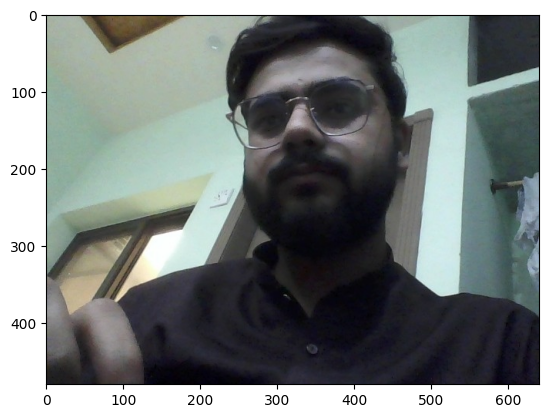

In [ ]:
t_im = cv2.imread("captured_image.jpg")
t_im.shape
t_im = cv2.cvtColor(t_im, cv2.COLOR_BGR2RGB)
x,y,w,h = mtcnn.detect_faces(t_im)[0]['box']

plt.imshow(t_im)

In [ ]:
print("Image size before resize:", t_im.shape)


Image size before resize: (480, 640, 3)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

t_im = t_im[y:y+h, x:x+w]
t_im = cv2.resize(t_im, (160,160))
test_im = get_embedding(t_im)

test_im = [test_im]

test_im = np.array(test_im)
flattened_image = test_im.flatten()

reshaped_image = flattened_image.reshape((1, 512))
# Make prediction
prediction = model.predict(reshaped_image)

predicted_label = np.argmax(prediction, axis=1)

# Print the predicted label
print("Predicted Label:", predicted_label)

lable=encoder.inverse_transform(predicted_label)
print(lable)

1/1 [==============================] - 0s 50ms/step
Predicted Label: [0]
['Ali 10']


In [ ]:
import pandas as pd
from datetime import datetime

# Create a DataFrame with the desired data
data = {'Time': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
        'Date': [datetime.now().strftime('%Y-%m-%d')],
        'Label': [lable],
        'Mark': ['present']}

df = pd.DataFrame(data)

# If the CSV file already exists, you can read it first and then append the new data
# If not, you can just save the DataFrame to a new CSV file
try:
    existing_df = pd.read_csv('your_file.csv')
    df = pd.concat([existing_df, df], ignore_index=True)
except FileNotFoundError:
    pass

# Save the DataFrame to a CSV file
df.to_csv('your_file.csv', index=False)


In [ ]:
df=pd.read_csv('your_file.csv')

In [ ]:

df.head()

,Time,Date,Label,Mark
0,2024-02-03 09:19:23,2024-02-03,['Ali 10'],present
